In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

# Set matplotlib color cycle
viridis_colors = plt.cm.viridis(np.linspace(0.1,0.9,6))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=viridis_colors)

# Set matplotlib color map
mpl.rc('image', cmap='viridis')

In [2]:
users = pd.read_csv('./takehome_users.csv', engine='python')
user_engagement = pd.read_csv('./takehome_user_engagement.csv', engine='python')

First, let's take a look at the data and do any necessary cleaning.

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Ok, we have some missing data in 'last_session_created_time' and 'invited_by_user_id'. I will assume that null values in the invited by column means that the user signed up by their own accord as was not invited. In this case I will full null values with a zero. Not sure why so much data is missing from the last session column. Let's start by filling null values with a zero here as well.

In [6]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(0)
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

Now let's take a look at the user engagement data:

In [7]:
user_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [8]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


OK, looks good. Before we can analyze user adoption we need to label each user and 'adopted' or 'not adopted'. This will be accomplished with a groupby of the user_engagement table on user_id and then a 7 day rolling window sum of the 'visited' column. Any users who have values >=7 can then be labeled as adopted and any with <7 as not adopted in the users table.

In [10]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
visits = user_engagement.groupby('user_id').rolling('7D', on='time_stamp').visited.sum().to_frame()
visits.reset_index(inplace=True)
visits.drop('time_stamp', axis=1, inplace=True)
visits['visited'] = visits['visited'].fillna(0)

Now get the maximum of visits for each user:

In [12]:
max_visits = visits.groupby('user_id')['visited'].max().to_frame()

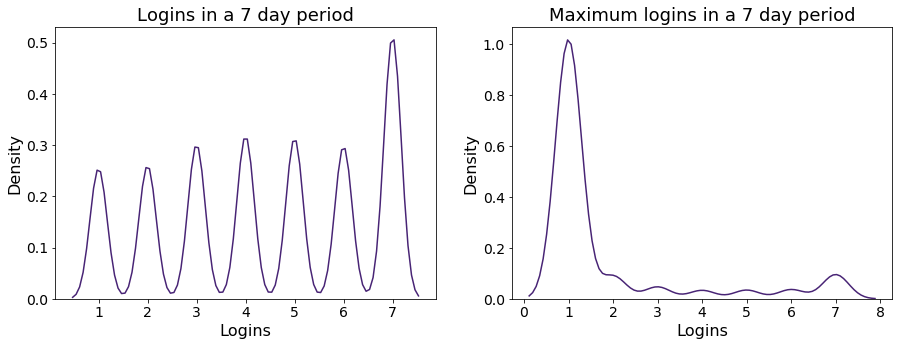

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(visits['visited'], ax=ax[0], legend=False)
ax[0].set_title('Logins in a 7 day period', fontsize=18)
ax[0].set_xlabel('Logins', fontsize=16)
ax[0].set_ylabel('Density', fontsize=16)
ax[0].tick_params(labelsize=14)

sns.kdeplot(max_visits['visited'], ax=ax[1], legend=False)
ax[1].set_title('Maximum logins in a 7 day period', fontsize=18)
ax[1].set_xlabel('Logins', fontsize=16)
ax[1].set_ylabel('Density', fontsize=16)
ax[1].tick_params(labelsize=14)

plt.show()

In [16]:
viridis_colors[0][0]

0.282623

In [17]:
mpl.cycler(color=viridis_colors)

"array([0.282623, 0.140926, 0.457517, 1. ])"
"array([0.225863, 0.330805, 0.547314, 1. ])"
"array([0.15627 , 0.489624, 0.557936, 1. ])"
"array([0.12478 , 0.640461, 0.527068, 1. ])"
"array([0.344074, 0.780029, 0.397381, 1. ])"
"array([0.741388, 0.873449, 0.149561, 1. ])"
